# WCF AI Training: End-to-End Machine Learning Project
## Project: Predicting Claim Fraud and Processing Time
---
This notebook provides a comprehensive walkthrough of a machine learning project, from understanding the business problem to preparing the model for deployment. We will use a sample dataset of WCF claims.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn for preprocessing and modeling
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics and Evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
print("Libraries imported successfully.")

Libraries imported successfully.


### 1. Look at the Big Picture
---
Before touching the data, we must define our goals and success criteria.

#### 1.1 Frame the Problem
*   **Business Objective:** To improve the integrity of the claims process by automatically identifying potentially fraudulent claims at the time of filing. This allows the Special Investigations Unit (SIU) to focus their efforts on the highest-risk cases, increasing efficiency and protecting the Fund's resources.
*   **Machine Learning Frame:** This is a **supervised, binary classification problem**.
    *   **Supervised:** We have historical data with claims already labeled as `Suspected_Fraud` (1) or not (0).
    *   **Binary Classification:** We are predicting one of two outcomes: Fraud (1) or Not Fraud (0).

#### 1.2 Select a Performance Measure
*   **Accuracy** (the percentage of correct predictions) can be misleading if the data is imbalanced (which it is here). A model that always predicts "Not Fraud" might be 99% accurate but is useless.
*   **Better Metrics for this problem:**
    *   **Precision:** Of all claims we flagged as fraud, how many were actually fraudulent? (Measures the cost of false positives).
    *   **Recall (Sensitivity):** Of all the actual fraudulent claims, how many did we successfully catch? (Measures the cost of false negatives).
    *   **AUC (Area Under the ROC Curve):** A single number that summarizes the model's ability to distinguish between the two classes. An AUC of 1.0 is perfect; 0.5 is no better than random guessing. We will use **AUC** as our primary optimization metric.

#### 1.3 Check the Assumptions
*   **Assumption 1:** The historical data is representative of future claims.
*   **Assumption 2:** The "Suspected_Fraud" label is a reliable ground truth for our training.
*   **Assumption 3:** The model's output (a probability score) can be integrated into the existing claims review workflow. We'll assume the SIU can work with a prioritized list of high-probability claims.

### 2. Get the Data
---
Now, we load the data and prepare it for exploration by creating a stable train/test split.

In [2]:
df = pd.read_csv('./datasets/synthetic_sample_claims.csv')
print("Dataset loaded. Shape:", df.shape)

Dataset loaded. Shape: (600, 16)


In [3]:
print("First 5 rows:")
display(df.head())

print("\nData Info:")
df.info()

print("\nStatistical Summary:")
display(df.describe())

print("\nDistribution of our target variable 'Suspected_Fraud':")
print(df['Suspected_Fraud'].value_counts(normalize=True))

First 5 rows:


,Claim_ID,Date_Filed,Region,Sector,Employer_Size,Channel,Claim_Type,Injured_Gender,Injury_Type,Age,Claim_Amount_TZS,Processing_Time_Days,Injury_Description,Suspected_Fraud,Claim_Status,Paid_Amount_TZS
0,WCF2022-00001,2021-04-08,Kilimanjaro,Agriculture,Large,Walk-in,Fatality,Male,Amputation,27,2642627,137,Incident involved amputation during loading/un...,0,Approved,2638599
1,WCF2024-00002,2023-04-28,Dodoma,Agriculture,Small,Online Portal,Medical Only,Female,Laceration,39,404552,24,Worker suffered a laceration while operating e...,0,Approved,369800
2,WCF2023-00003,2022-12-18,Mtwara,Construction,Small,Walk-in,Medical Only,Female,Concussion,27,497479,18,Reported concussion due to slip and fall in th...,0,Approved,468173
3,WCF2023-00004,2022-04-26,Mtwara,Mining,Micro,Employer Submission,Medical Only,Male,Fracture,22,226753,16,Claim notes indicate fracture with moderate se...,0,Approved,223881
4,WCF2023-00005,2022-04-20,Dodoma,Public Admin,Small,Walk-in,Medical Only,Female,Sprain/Strain,31,450381,18,Incident involved sprain/strain during loading...,0,Approved,445898



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Claim_ID              600 non-null    object
 1   Date_Filed            600 non-null    object
 2   Region                600 non-null    object
 3   Sector                600 non-null    object
 4   Employer_Size         600 non-null    object
 5   Channel               600 non-null    object
 6   Claim_Type            600 non-null    object
 7   Injured_Gender        600 non-null    object
 8   Injury_Type           600 non-null    object
 9   Age                   600 non-null    int64 
 10  Claim_Amount_TZS      600 non-null    int64 
 11  Processing_Time_Days  600 non-null    int64 
 12  Injury_Description    600 non-null    object
 13  Suspected_Fraud       600 non-null    int64 
 14  Claim_Status          600 non-null    object
 15  Paid_Amount_TZS       600 no

,Age,Claim_Amount_TZS,Processing_Time_Days,Suspected_Fraud,Paid_Amount_TZS
count,600.000000,6.000000e+02,600.000000,600.000000,6.000000e+02
mean,33.746667,7.388469e+05,33.386667,0.015000,5.494758e+05
std,8.729997,6.318475e+05,28.279203,0.121654,5.378819e+05
min,18.000000,1.000000e+05,3.000000,0.000000,0.000000e+00
25%,27.000000,3.609965e+05,18.000000,0.000000,1.403160e+05
50%,34.000000,6.156110e+05,24.000000,0.000000,4.349285e+05
75%,39.000000,9.005845e+05,37.000000,0.000000,7.576250e+05
max,65.000000,7.274465e+06,176.000000,1.000000,4.438758e+06



Distribution of our target variable 'Suspected_Fraud':
Suspected_Fraud
0    0.985
1    0.015
Name: proportion, dtype: float64


#### 2.1 Create a Test Set
**CRITICAL STEP:** We must create a test set *before* any data exploration to prevent data snooping bias. Because our fraud data is imbalanced, we will use **Stratified Sampling** to ensure both the training and test sets have a similar percentage of fraudulent cases.

In [4]:
# We use StratifiedShuffleSplit to create a single, stable split.
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(df, df['Suspected_Fraud']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

print("Training set shape:", strat_train_set.shape)
print("Test set shape:", strat_test_set.shape)

print("\nFraud distribution in full dataset:\n", df['Suspected_Fraud'].value_counts(normalize=True))
print("\nFraud distribution in test set:\n", strat_test_set['Suspected_Fraud'].value_counts(normalize=True))

Training set shape: (480, 16)
Test set shape: (120, 16)

Fraud distribution in full dataset:
 Suspected_Fraud
0    0.985
1    0.015
Name: proportion, dtype: float64

Fraud distribution in test set:
 Suspected_Fraud
0    0.983333
1    0.016667
Name: proportion, dtype: float64


### 3. Explore and Visualize the Data
---
Now, using **only the training set**, we'll dive deeper to find patterns.

In [5]:
claims_explore = strat_train_set.copy()

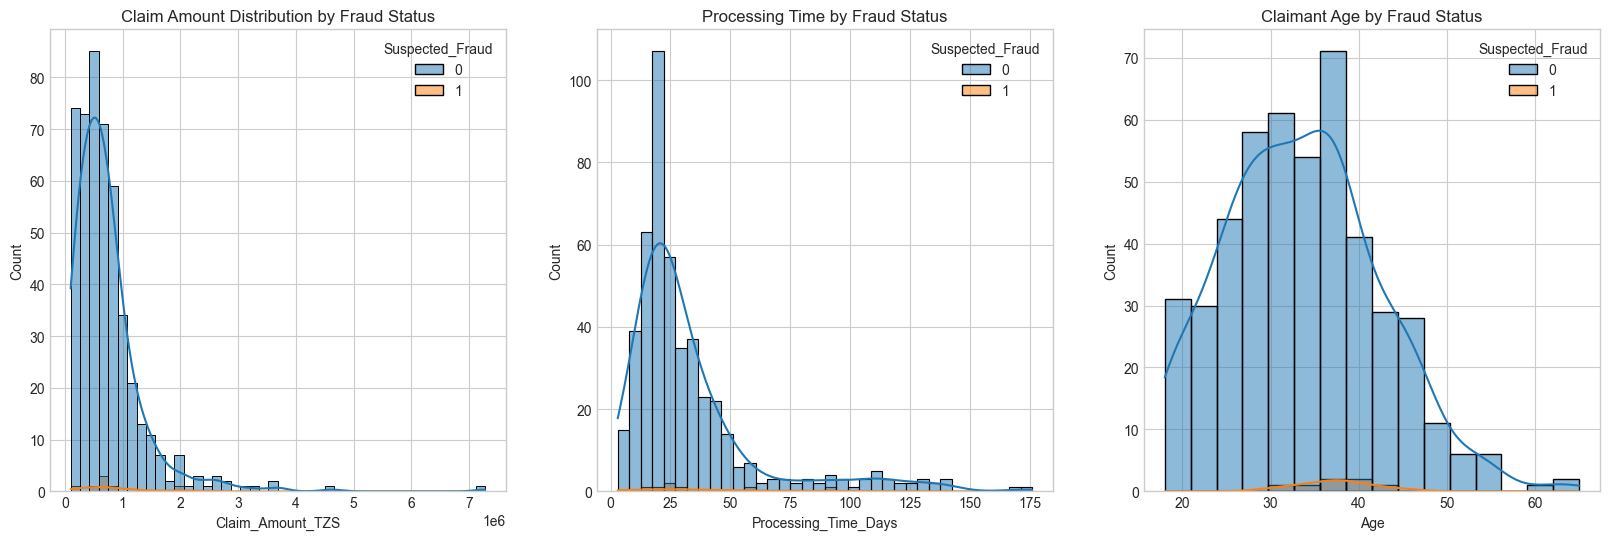

In [6]:
# Look for differences between fraudulent and non-fraudulent claims
fraud_claims = claims_explore[claims_explore['Suspected_Fraud'] == 1]
non_fraud_claims = claims_explore[claims_explore['Suspected_Fraud'] == 0]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(data=claims_explore, x='Claim_Amount_TZS', hue='Suspected_Fraud', kde=True, ax=axes[0])
axes[0].set_title('Claim Amount Distribution by Fraud Status')

sns.histplot(data=claims_explore, x='Processing_Time_Days', hue='Suspected_Fraud', kde=True, ax=axes[1])
axes[1].set_title('Processing Time by Fraud Status')

sns.histplot(data=claims_explore, x='Age', hue='Suspected_Fraud', kde=True, ax=axes[2])
axes[2].set_title('Claimant Age by Fraud Status')
plt.show()

#### 3.1 Look for Correlations
Let's see which numerical features are correlated with fraud.

In [7]:
# We need to convert Suspected_Fraud to numeric for correlation
corr_matrix = claims_explore.corr(numeric_only=True)
print(corr_matrix["Suspected_Fraud"].sort_values(ascending=False))

Suspected_Fraud         1.000000
Age                     0.052000
Paid_Amount_TZS         0.026716
Processing_Time_Days    0.020396
Claim_Amount_TZS        0.008100
Name: Suspected_Fraud, dtype: float64


**Insight:** `Claim_Amount_TZS` and `Processing_Time_Days` seem to have a positive correlation with fraud, which makes business sense. Higher value, longer-to-process claims might be more likely to be fraudulent.

#### 3.2 Experiment with Attribute Combinations
Creating new features (Feature Engineering) is key to improving model performance.

In [8]:
claims_explore['Amount_Per_Day'] = claims_explore['Claim_Amount_TZS'] / (claims_explore['Processing_Time_Days'] + 1) # Add 1 to avoid division by zero
claims_explore['Age_Squared'] = claims_explore['Age']**2

# Re-check correlations with new features
new_corr_matrix = claims_explore.corr(numeric_only=True)
print(new_corr_matrix["Suspected_Fraud"].sort_values(ascending=False))

Suspected_Fraud         1.000000
Age                     0.052000
Age_Squared             0.039630
Paid_Amount_TZS         0.026716
Processing_Time_Days    0.020396
Claim_Amount_TZS        0.008100
Amount_Per_Day         -0.035097
Name: Suspected_Fraud, dtype: float64


### 4. Prepare the Data for Machine Learning Algorithms
---
We will now build a robust preprocessing pipeline. This section is highly technical and critical for production systems.

In [9]:
X_train = strat_train_set.drop("Suspected_Fraud", axis=1)
y_train = strat_train_set["Suspected_Fraud"].copy()

#### 4.1 Data Cleaning & Custom Transformers
We'll create a custom transformer to perform our feature engineering steps. This makes our pipeline cleaner and more modular.

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        # Date Features
        X_copy['Date_Filed'] = pd.to_datetime(X_copy['Date_Filed'])
        X_copy['Filing_Year'] = X_copy['Date_Filed'].dt.year
        X_copy['Filing_Month'] = X_copy['Date_Filed'].dt.month
        
        # Interaction Features
        X_copy['Amount_Per_Day'] = X_copy['Claim_Amount_TZS'] / (X_copy['Processing_Time_Days'] + 1)
        
        # Text-based Features
        X_copy['Description_Length'] = X_copy['Injury_Description'].str.len()
        
        # Drop original columns we no longer need
        return X_copy.drop(['Claim_ID', 'Date_Filed', 'Injury_Description', 'Paid_Amount_TZS'], axis=1)

#### 4.2 Handling Text, Categorical Attributes, Scaling, and the Full Pipeline

In [11]:
# Identify column types from the *engineered* dataframe
temp_featurizer = FeatureEngineer()
X_train_featured = temp_featurizer.fit_transform(X_train)

numerical_features = X_train_featured.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train_featured.select_dtypes(exclude=np.number).columns.tolist()

# Define individual pipelines for numeric and categorical data
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine everything into a single preprocessor
full_preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features)
])

# Create the final, full pipeline that includes feature engineering and preprocessing
# We wrap our FeatureEngineer transformer using FunctionTransformer to make it compatible
feature_pipeline = Pipeline([
    ('feature_engineer', FeatureEngineer()),
    ('preprocessor', full_preprocessor)
])

# Test the pipeline
X_train_prepared = feature_pipeline.fit_transform(X_train)
print("Data preparation pipeline built successfully.")
print("Shape of prepared training data:", X_train_prepared.shape)

Data preparation pipeline built successfully.
Shape of prepared training data: (480, 55)


### 5. Select and Train a Model
---
We'll start with a simple baseline (Logistic Regression) and then a more powerful one (Random Forest).

In [12]:
# Create a full pipeline that includes the model
log_reg_pipeline = Pipeline([
    ('preparation', feature_pipeline),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

log_reg_pipeline.fit(X_train, y_train)

# Evaluate on training data (just for a baseline check)
y_train_pred_lr = log_reg_pipeline.predict(X_train)
print("--- Logistic Regression (Baseline) ---")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_lr))
print(classification_report(y_train, y_train_pred_lr))

--- Logistic Regression (Baseline) ---
Training Accuracy: 0.95625
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       473
           1       0.25      1.00      0.40         7

    accuracy                           0.96       480
   macro avg       0.62      0.98      0.69       480
weighted avg       0.99      0.96      0.97       480



In [13]:
rf_pipeline = Pipeline([
    ('preparation', feature_pipeline),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rf_pipeline.fit(X_train, y_train)

# Evaluate on training data
y_train_pred_rf = rf_pipeline.predict(X_train)
print("--- Random Forest ---")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_rf))
print(classification_report(y_train, y_train_pred_rf))

--- Random Forest ---
Training Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       473
           1       1.00      1.00      1.00         7

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



**Insight:** The Random Forest achieves 100% accuracy and perfect scores on the training data. This is a strong sign of **overfitting**, which we'll address.

### 6. Fine-Tune the Model
---
We'll use GridSearchCV to find the best hyperparameters for our Random Forest model and combat overfitting.

In [14]:
# Define a parameter grid to search
# We add classifier__ to specify that these parameters are for the 'classifier' step of the pipeline
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', None]
}

# We use Stratified K-Fold for cross-validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

grid_search = GridSearchCV(rf_pipeline, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation AUC score: ", grid_search.best_score_)

# The best estimator is now our fine-tuned model
final_model = grid_search.best_estimator_

Best parameters found:  {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200}
Best cross-validation AUC score:  0.6463157894736842


#### 6.1 Analyze the Best Model and its Errors
Let's look at what features our tuned model found most important.

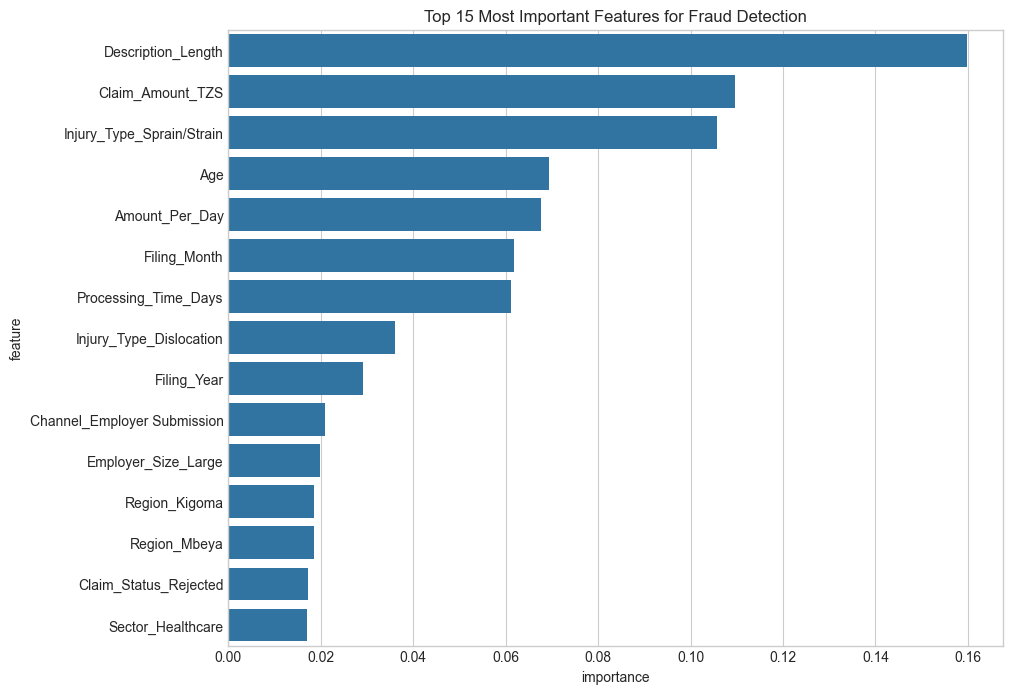

In [15]:
# We need to get the feature names from the preprocessor step
preprocessor_step = final_model.named_steps['preparation'].named_steps['preprocessor']
cat_features_out = preprocessor_step.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_features_out])

# Get importances from the classifier step
importances = final_model.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Most Important Features for Fraud Detection')
plt.show()

#### 6.2 Evaluate the System on the Test Set
This is the final step before deployment. We use our **held-out test set** for the first time to get an unbiased estimate of the model's performance.

--- Final Model Evaluation on Test Set ---
Test Accuracy: 0.9833
Test AUC Score: 0.6525

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       118
           1       0.00      0.00      0.00         2

    accuracy                           0.98       120
   macro avg       0.49      0.50      0.50       120
weighted avg       0.97      0.98      0.98       120



/Users/aronkondoro/Library/Mobile Documents/com~apple~CloudDocs/Projects/WCF/base/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/aronkondoro/Library/Mobile Documents/com~apple~CloudDocs/Projects/WCF/base/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/aronkondoro/Library/Mobile Documents/com~apple~CloudDocs/Projects/WCF/base/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set t

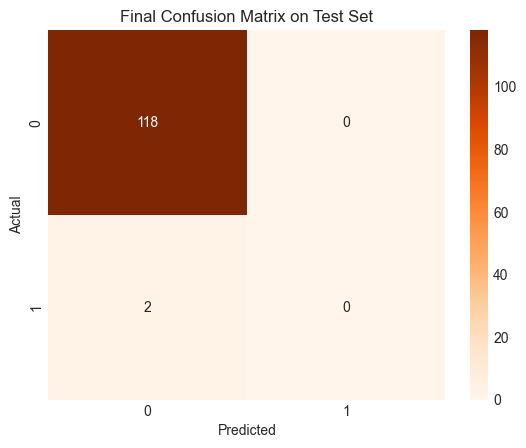

In [12]:
# Separate test features and labels
X_test = strat_test_set.drop("Suspected_Fraud", axis=1)
y_test = strat_test_set["Suspected_Fraud"].copy()

# Make predictions on the test set
final_predictions = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1] # Probability of being fraud

# Print final metrics
print("--- Final Model Evaluation on Test Set ---")
print(f"Test Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print(f"Test AUC Score: {roc_auc_score(y_test, final_proba):.4f}")
print("\nClassification Report:\n", classification_report(y_test, final_predictions))

# Final Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Final Confusion Matrix on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 7. Launch, Monitor, and Maintain the System
---
The model is built and evaluated. Now we prepare it for production.

#### 7.1 Monitoring and Maintenance Plan
*   **Launch:** Deploy the saved `wcf_fraud_detection_pipeline.pkl` as a web service (API). The claims processing system will send the data for each new claim to this API.
*   **Monitor:**
    *   **Performance:** Regularly (e.g., quarterly), compare the model's predictions against the outcomes of investigations to track its real-world precision and recall.
    *   **Data Drift:** Monitor the statistical distribution of incoming data. If the average `Claim_Amount_TZS` suddenly doubles, the model's performance may degrade. This should trigger an alert.
*   **Maintain:**
    *   **Retraining:** Schedule a job to automatically retrain the model on fresh, labeled data (e.g., every 6 months) to keep it up-to-date with new fraud patterns.
    *   **Versioning:** Keep versions of the model, so if a new model performs worse, we can easily roll back to the previous version.

In [35]:
import joblib

# Save the entire pipeline (feature engineering, preprocessing, and model)
joblib.dump(final_model, 'wcf_fraud_detection_pipeline.pkl')
print("Final model pipeline saved to 'wcf_fraud_detection_pipeline.pkl'")

# You can now load this pipeline in another script or a web API
# loaded_pipeline = joblib.load('wcf_fraud_detection_pipeline.pkl')
# predictions = loaded_pipeline.predict(new_data_df)

Final model pipeline saved to 'wcf_fraud_detection_pipeline.pkl'


### ==============================================================================
### Step 8: Interacting with the Deployed Model
### ==============================================================================

Now that we have a saved pipeline (`wcf_fraud_detection_pipeline.pkl`), how would another part of the WCF system—like the main claims intake application—actually use it?

Let's simulate this process. We will:
1.  Load our saved pipeline.
2.  Create some new, hypothetical claim data as if it just arrived.
3.  Feed this new data to the pipeline to get a fraud prediction.

In [37]:
import joblib
import pandas as pd

# Load the entire pipeline object from the file
# This object contains all our steps: feature engineering, scaling, encoding, and the trained model.
loaded_fraud_pipeline = joblib.load('wcf_fraud_detection_pipeline.pkl')

print("Fraud detection pipeline loaded successfully!")
print("Pipeline steps:", loaded_fraud_pipeline.steps)

Fraud detection pipeline loaded successfully!
Pipeline steps: [('preparation', Pipeline(steps=[('feature_engineer', FeatureEngineer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Claim_Amount_TZS',
                                                   'Processing_Time_Days',
                                                   'Filing_Year',
                                                   'Filing_Month',
                                                   'Amount_Per_Day',
                                                   'Description_Length']),

#### Creating New Sample Claims

Now, let's create a couple of new, unseen claims. It's crucial that this new data is in the **same raw format** as our original CSV file, with the same column names. The pipeline will handle all the necessary transformations for us.

We'll create two examples:
*   A "normal-looking" claim.
*   A "suspicious-looking" claim with characteristics that might indicate fraud (e.g., very high claim amount, long processing time, a high-risk sector).

In [38]:
# Note: The structure must match the original input data EXACTLY.
# The pipeline expects all the same columns it was trained on.
new_claims_data = {
    'Claim_ID': ['WCF2025-0001', 'WCF2025-0002'],
    'Date_Filed': ['2024-05-15', '2024-05-16'],
    'Region': ['Dar es Salaam', 'Mwanza'],
    'Sector': ['Construction', 'Retail'],
    'Employer_Size': ['Micro', 'Large'],
    'Channel': ['Online Portal', 'Walk-in'],
    'Claim_Type': ['Lost Time', 'Permanent Disability'],
    'Injured_Gender': ['Male', 'Female'],
    'Injury_Type': ['Fracture', 'Sprain/Strain'],
    'Age': [28, 55],
    'Claim_Amount_TZS': [750000, 7500000], # Claim 2 is very high value
    'Processing_Time_Days': [25, 180], # Claim 2 has a very long processing time
    'Injury_Description': [
        'Worker reported a minor fracture after a slip at the construction site.',
        'Complex strain injury with conflicting doctor reports and delayed filing.'
    ],
    'Claim_Status': ['Pending Review', 'Pending Review'],
    # We don't include 'Suspected_Fraud' or 'Paid_Amount_TZS' as these are what we predict or come after.
    # The pipeline will ignore the target variable column anyway if it's present.
}

new_claims_df = pd.DataFrame(new_claims_data)

print("New claims data created:")
display(new_claims_df)

New claims data created:


,Claim_ID,Date_Filed,Region,Sector,Employer_Size,Channel,Claim_Type,Injured_Gender,Injury_Type,Age,Claim_Amount_TZS,Processing_Time_Days,Injury_Description,Claim_Status
0,WCF2025-0001,2024-05-15,Dar es Salaam,Construction,Micro,Online Portal,Lost Time,Male,Fracture,28,750000,25,Worker reported a minor fracture after a slip ...,Pending Review
1,WCF2025-0002,2024-05-16,Mwanza,Retail,Large,Walk-in,Permanent Disability,Female,Sprain/Strain,55,7500000,180,Complex strain injury with conflicting doctor ...,Pending Review


#### Making Predictions with the Pipeline

This is the simplest step. We just call the `.predict()` or `.predict_proba()` method on our loaded pipeline, passing in the new data. The pipeline handles everything internally.

In [39]:
# Get the fraud prediction (0 for Not Fraud, 1 for Suspected Fraud)
fraud_predictions = loaded_fraud_pipeline.predict(new_claims_df)

# Get the probability scores for each class [Prob(Not Fraud), Prob(Fraud)]
fraud_probabilities = loaded_fraud_pipeline.predict_proba(new_claims_df)


# --- Display the results in a user-friendly way ---

for i in range(len(new_claims_df)):
    claim_id = new_claims_df.loc[i, 'Claim_ID']
    prediction_label = "Suspected Fraud" if fraud_predictions[i] == 1 else "Not Fraud"
    probability_score = fraud_probabilities[i][1] # Probability of being class '1' (Fraud)
    
    print(f"\n--- Prediction for Claim: {claim_id} ---")
    print(f"Predicted Outcome: {prediction_label}")
    print(f"Fraud Probability Score: {probability_score:.2%}")
    
    # Add a simple business rule for interpretation
    if probability_score > 0.5: # This threshold can be tuned
        print("Recommendation: Flag for review by Special Investigations Unit.")
    else:
        print("Recommendation: Proceed with standard processing.")


--- Prediction for Claim: WCF2025-0001 ---
Predicted Outcome: Not Fraud
Fraud Probability Score: 0.06%
Recommendation: Proceed with standard processing.

--- Prediction for Claim: WCF2025-0002 ---
Predicted Outcome: Not Fraud
Fraud Probability Score: 5.74%
Recommendation: Proceed with standard processing.
